In [27]:
import numpy as np
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy

In [19]:
# Step 1: Extract images from ZIP file
zip_file_path = 'images.zip'  # Change this to your actual ZIP file path
extract_folder = 'extracted_images'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


In [20]:
# Check the contents of the extracted directory
images_dir = os.path.join(extract_folder, 'images')  # Adjust the path to your images folder
print("Contents of extracted images directory:", os.listdir(images_dir))

Contents of extracted images directory: ['01_01.jpg', '01_01_r.jpg', '01_01_y-flip.jpg', '01_01_y-flip_r.jpg', '01_02.jpg', '01_02_r.jpg', '01_02_y-flip.jpg', '01_02_y-flip_r.jpg', '01_03.jpg', '01_03_r.jpg', '01_03_y-flip.jpg', '01_03_y-flip_r.jpg', '01_04.jpg', '01_04_r.jpg', '01_04_y-flip.jpg', '01_04_y-flip_r.jpg', '02_01.jpg', '02_01_r.jpg', '02_01_y-flip.jpg', '02_01_y-flip_r.jpg', '02_02.jpg', '02_02_r.jpg', '02_02_y-flip.jpg', '02_02_y-flip_r.jpg', '03_01.jpg', '03_01_r.jpg', '03_01_x-flip.jpg', '03_01_x-flip_r.jpg', '03_02.jpg', '03_02_r.jpg', '03_02_x-flip.jpg', '03_02_x-flip_r.jpg', '03_03.jpg', '03_03_r.jpg', '03_03_x-flip.jpg', '03_03_x-flip_r.jpg', '03_04.jpg', '03_04_r.jpg', '03_04_x-flip.jpg', '03_04_x-flip_r.jpg', '03_05.jpg', '03_05_r.jpg', '03_05_x-flip.jpg', '03_05_x-flip_r.jpg', '03_06.jpg', '03_06_r.jpg', '03_06_x-flip.jpg', '03_06_x-flip_r.jpg', '04_01.jpg', '04_01_r.jpg', '04_01_y-flip.jpg', '04_01_y-flip_r.jpg', '04_02.jpg', '04_02_r.jpg', '04_02_y-flip.jpg', '

In [21]:
# Step 2: Create a function to generate the label dictionary
def create_label_dict(images_dir):
    label_dict = {}
    for filename in os.listdir(images_dir):
        print("Processing file:", filename)  # Debugging line
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Check file extension
            if '_r' in filename:
                label_dict[filename] = 0  # No illusion
            elif '_y-flip_r' in filename or '_x-flip_r' in filename:
                label_dict[filename] = 0  # No illusion but flipped
            elif filename.endswith('.jpg') and not ('_r' in filename or '_flip' in filename):
                label_dict[filename] = 1  # Illusion
            elif '_y-flip' in filename or '_x-flip' in filename:
                label_dict[filename] = 1  # Flipped illusion
            else:
                print(f"Unmatched condition for: {filename}")  # Debugging unmatched files
    return label_dict

In [22]:
# Step 3: Generate the label dictionary
label_dict = create_label_dict(images_dir)
print("Label dictionary created:", label_dict)

# Prepare data for training, validation, and testing
data = [(filename, label) for filename, label in label_dict.items()]

# Shuffle and split the dataset into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=31)  # 70% train, 30% temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=31)  # 15% val, 15% test

# Output the sizes of the datasets
print("Training data:", len(train_data))
print("Validation data:", len(val_data))
print("Testing data:", len(test_data))


Processing file: 01_01.jpg
Processing file: 01_01_r.jpg
Processing file: 01_01_y-flip.jpg
Processing file: 01_01_y-flip_r.jpg
Processing file: 01_02.jpg
Processing file: 01_02_r.jpg
Processing file: 01_02_y-flip.jpg
Processing file: 01_02_y-flip_r.jpg
Processing file: 01_03.jpg
Processing file: 01_03_r.jpg
Processing file: 01_03_y-flip.jpg
Processing file: 01_03_y-flip_r.jpg
Processing file: 01_04.jpg
Processing file: 01_04_r.jpg
Processing file: 01_04_y-flip.jpg
Processing file: 01_04_y-flip_r.jpg
Processing file: 02_01.jpg
Processing file: 02_01_r.jpg
Processing file: 02_01_y-flip.jpg
Processing file: 02_01_y-flip_r.jpg
Processing file: 02_02.jpg
Processing file: 02_02_r.jpg
Processing file: 02_02_y-flip.jpg
Processing file: 02_02_y-flip_r.jpg
Processing file: 03_01.jpg
Processing file: 03_01_r.jpg
Processing file: 03_01_x-flip.jpg
Processing file: 03_01_x-flip_r.jpg
Processing file: 03_02.jpg
Processing file: 03_02_r.jpg
Processing file: 03_02_x-flip.jpg
Processing file: 03_02_x-fli

In [23]:
# Step 4: Create data generators for training, validation, and testing
def create_data_generator(data, images_dir, batch_size=32, target_size=(150, 150)):
    filenames, labels = zip(*data)  # Unzip data
    labels = list(map(str, labels))  # Convert labels to strings

    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': filenames, 'label': labels}),
        directory=images_dir,
        x_col='filename',
        y_col='label',
        target_size=target_size,
        class_mode='binary',
        batch_size=batch_size
    )
    return generator

train_generator = create_data_generator(train_data, images_dir)
val_generator = create_data_generator(val_data, images_dir)
test_generator = create_data_generator(test_data, images_dir)

Found 142 validated image filenames belonging to 2 classes.


Found 31 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


In [ ]:
# Calculate class weights
from sklearn.utils import class_weight
# Extract labels from the training data
train_labels = [label for _, label in train_data]

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Define Focal Loss
class FocalLoss(BinaryCrossentropy):
    def __init__(self, gamma=2, alpha=0.25, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        bce = super().call(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = tf.pow((1 - p_t), self.gamma)
        return alpha_factor * modulating_factor * bce


In [25]:
# Step 5: Build a model using VGG16 with focal loss
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    # Unfreeze the top layers of the model
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=1e-5), loss=FocalLoss(), metrics=['accuracy'])
    return model

model = create_vgg16_model()

In [ ]:
# Step 6: Build a model using InceptionV3
def create_inceptionv3_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_inceptionv3_model()



87910968/87910968 [==============================] - 9s 0us/step


In [ ]:
# Step 7: Run the model and estimate the metrics

from sklearn.metrics import confusion_matrix, classification_report
models = {
    'VGG16': create_vgg16_model(),
    'InceptionV3': create_inceptionv3_model()
}
results = {}
for model_name, model in models.items():
        model.fit(train_generator, validation_data=val_generator, epochs=10, class_weight=class_weights)
        test_loss, test_accuracy = model.evaluate(test_generator)
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)
        predicted_classes = ['Illusion' if pred > 0.5 else 'No Illusion' for pred in predictions]
        predicted_labels = [1 if label == 'Illusion' else 0 for label in predicted_classes]

        # Ensure test_labels are in the correct format (binary: 0 or 1)
        test_labels = test_labels.astype(int)

        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(test_labels, predicted_labels)
        # Print a classification report for more detailed metrics
        classification_rep = classification_report(test_labels, predicted_labels, target_names=["No Illusion", "Illusion"], output_dict=True)
         
         # Store the results
        results[model_name] = {
            'conf_matrix': conf_matrix,
            'classification_report': classification_rep,
            'test_accuracy': test_accuracy
            }

for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['classification_report'])
    print("Accuracy:")
    print(result['test_accuracy'])
    print("\n")  


Epoch 1/10
5/5 [==============================] - 46s 8s/step - loss: 0.0835 - accuracy: 0.5211 - val_loss: 0.0517 - val_accuracy: 0.5806
Epoch 2/10
5/5 [==============================] - 36s 7s/step - loss: 0.0508 - accuracy: 0.6408 - val_loss: 0.0435 - val_accuracy: 0.6129
Epoch 3/10
5/5 [==============================] - 37s 7s/step - loss: 0.0361 - accuracy: 0.6972 - val_loss: 0.0361 - val_accuracy: 0.7097
Epoch 4/10
5/5 [==============================] - 36s 7s/step - loss: 0.0233 - accuracy: 0.8169 - val_loss: 0.0299 - val_accuracy: 0.6774
Epoch 5/10
5/5 [==============================] - 36s 7s/step - loss: 0.0175 - accuracy: 0.8239 - val_loss: 0.0258 - val_accuracy: 0.7097
Epoch 6/10
5/5 [==============================] - 36s 7s/step - loss: 0.0092 - accuracy: 0.9085 - val_loss: 0.0239 - val_accuracy: 0.7419
Epoch 7/10
5/5 [==============================] - 36s 7s/step - loss: 0.0064 - accuracy: 0.9225 - val_loss: 0.0230 - val_accuracy: 0.7742
Epoch 8/10
5/5 [==================

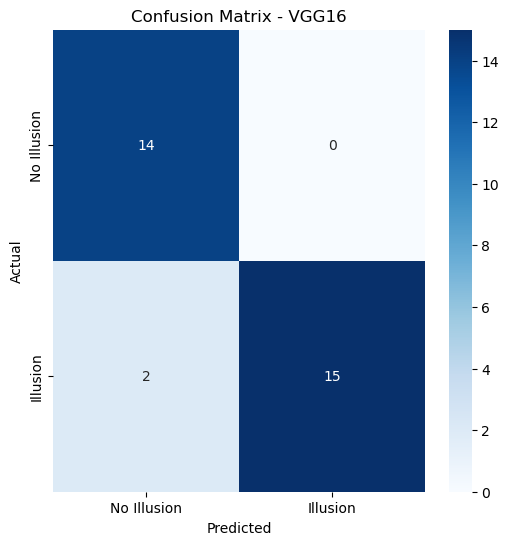

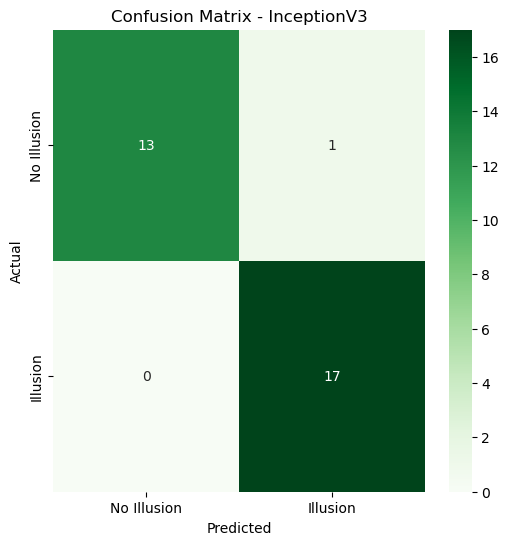

In [45]:
cm_vgg16 = results['VGG16']['conf_matrix']
cm_inception = results['InceptionV3']['conf_matrix']
import seaborn as sns


def plot_confusion_matrix(cm, model_name, cmap):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=["No Illusion", "Illusion"], yticklabels=["No Illusion", "Illusion"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
plot_confusion_matrix(cm_vgg16, "VGG16", cmap="Blues")
plot_confusion_matrix(cm_inception, "InceptionV3", cmap="Greens")


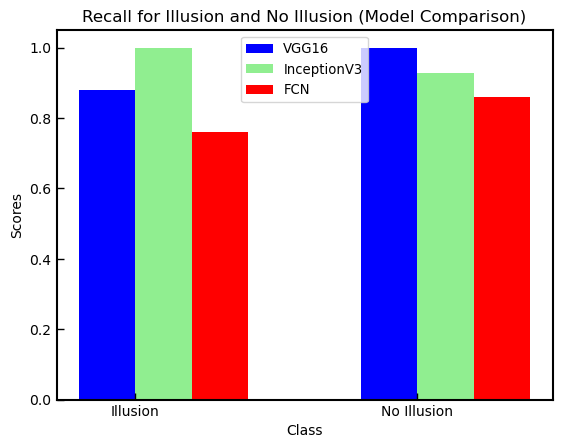

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Extract precision and recall for illusion and no-illusion classes for both models
precision_illusion_1 = 1.0
precision_no_illusion_1 = 0.875
recall_illusion_1 = 0.88
recall_no_illusion_1 = 1.0

precision_illusion_2 = 0.944
precision_no_illusion_2 = 1.0
recall_illusion_2 = 1.0
recall_no_illusion_2 = 0.928

precision_illusion_3 = 0.87
precision_no_illusion_3 = 0.75
recall_illusion_3 = 0.76
recall_no_illusion_3 = 0.86

# Bar chart for precision and recall for both models
labels = ['Illusion', 'No Illusion']
precision_model_1 = [precision_illusion_1, precision_no_illusion_1]
recall_model_1 = [recall_illusion_1, recall_no_illusion_1]
precision_model_2 = [precision_illusion_2, precision_no_illusion_2]
recall_model_2 = [recall_illusion_2, recall_no_illusion_2]
precision_model_3 = [precision_illusion_3, precision_no_illusion_3]
recall_model_3 = [recall_illusion_3, recall_no_illusion_3]



x = np.arange(len(labels))  # The label locations
width = 0.2  # The width of the bars

fig, ax = plt.subplots()

# Create bars for precision and recall for both models
#bars1_precision = ax.bar(x - width/2, precision_model_1, width, label='VGG16', color='blue')
bars1_recall = ax.bar(x - width/2, recall_model_1, width, label='VGG16', color='blue')
#bars2_precision = ax.bar(x + width/2, precision_model_2, width, label='InceptionV3', color='lightgreen')
bars2_recall = ax.bar(x + width/2, recall_model_2, width, label='InceptionV3', color='lightgreen')
#bars3_precision = ax.bar(x + 0.3, precision_model_3, width, label='FCN', color='Red')
bars3_recall = ax.bar(x + 0.3, recall_model_3, width, label='FCN', color='Red')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Recall for Illusion and No Illusion (Model Comparison)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.tick_params(axis='both',direction = 'in',which='both')
ax.tick_params(axis='both',which='major',length=5, width=1)
ax.tick_params(axis='both',which='minor',length=2.5)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
ax.legend(fontsize = 9.5, loc ="upper center")

# Display the plot
plt.show()
